In [23]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import cross_val_score, cross_validate, learning_curve
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [24]:
BASE_DIR = Path("../")
MODELS_DIR = BASE_DIR / "output" / "models"
FEATURES_FILE = BASE_DIR / "data" / "processed" / "features" / "features.csv"
OUTPUT_DIR = BASE_DIR / "output" 
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Models directory: {MODELS_DIR}")
print(f"Features file: {FEATURES_FILE}")
print(f"Output directory: {OUTPUT_DIR}")

Models directory: ../output/models
Features file: ../data/processed/features/features.csv
Output directory: ../output


In [25]:
def load_all_models():
    
    with open(MODELS_DIR / 'all_models.pkl', 'rb') as f:
        all_models = pickle.load(f)
    
    with open(MODELS_DIR / 'preprocessing.pkl', 'rb') as f:
        preprocessing = pickle.load(f)
    
    with open(MODELS_DIR / 'training_results.pkl', 'rb') as f:
        training_results = pickle.load(f)
    
    with open(MODELS_DIR / 'model_metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    with open(MODELS_DIR / 'data_splits.pkl', 'rb') as f:
        data_splits = pickle.load(f)
    
    return all_models, preprocessing, training_results, metadata, data_splits

# Load all artifacts
all_models, preprocessing, training_results, metadata, data_splits = load_all_models()

print("Loaded all model artifacts:")
print(f"Tasks: {list(all_models.keys())}")
print(f"Total models: {metadata['total_models']}")
print(f"Training timestamp: {metadata['timestamp']}")

for task, models in all_models.items():
    n_samples = len(data_splits[task]['y_full'])
    n_features = len(data_splits[task]['feature_names'])
    print(f"\n{task}:")
    print(f"  - Data: {n_samples} samples, {n_features} features")
    print(f"  - Models: {list(models.keys())}")

Loaded all model artifacts:
Tasks: ['world_record_residual', 'american_record_residual', 'us_open_record_residual', 'top_seed_win']
Total models: 18
Training timestamp: 2025-06-29T12:17:15.111472

world_record_residual:
  - Data: 483 samples, 50 features
  - Models: ['ridge', 'lasso', 'elastic_net', 'random_forest', 'gradient_boosting']

american_record_residual:
  - Data: 476 samples, 50 features
  - Models: ['ridge', 'lasso', 'elastic_net', 'random_forest', 'gradient_boosting']

us_open_record_residual:
  - Data: 417 samples, 50 features
  - Models: ['ridge', 'lasso', 'elastic_net', 'random_forest', 'gradient_boosting']

top_seed_win:
  - Data: 490 samples, 50 features
  - Models: ['logistic_regression', 'random_forest', 'gradient_boosting']


In [35]:
def create_training_results_comparison():

    # Prepare data for comparison
    comparison_data = []
    
    for task_name, task_results in training_results.items():
        for model_name, metrics in task_results.items():
            row = {
                'Task': task_name,
                'Model': model_name,
                'Task_Type': 'Classification' if task_name == 'top_seed_win' else 'Regression'
            }
            
            if task_name == 'top_seed_win':
                # Classification metrics
                row.update({
                    'Test_Accuracy': metrics.get('test_accuracy', 0),
                    'Test_F1': metrics.get('test_f1', 0),
                    'Test_AUC': metrics.get('test_auc', 0),
                    'Test_Precision': metrics.get('test_precision', 0),
                    'Test_Recall': metrics.get('test_recall', 0)
                })
            else:
                # Regression metrics
                row.update({
                    'Train_R2': metrics.get('train_r2', 0),
                    'Test_R2': metrics.get('test_r2', 0),
                    'Test_RMSE': metrics.get('test_rmse', 0),
                    'Test_MAE': metrics.get('test_mae', 0),
                    'Overfitting': metrics.get('train_r2', 0) - metrics.get('test_r2', 0)
                })
            
            comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

# Create comparison
results_comparison = create_training_results_comparison()

# Display regression results
regression_results = results_comparison[results_comparison['Task_Type'] == 'Regression'].copy()
classification_results = results_comparison[results_comparison['Task_Type'] == 'Classification'].copy()

print("REGRESSION TASKS COMPARISON:")
for task in regression_results['Task'].unique():
    task_data = regression_results[regression_results['Task'] == task].copy()
    task_data = task_data.sort_values('Test_R2', ascending=False)
    
    print(f"\n{task.upper()}:")
    print(f"{'Model':<20} {'Test R²':<10} {'Test RMSE':<12} {'Overfitting':<12}")
    
    for _, row in task_data.iterrows():
        print(f"{row['Model']:<20} {row['Test_R2']:<10.3f} {row['Test_RMSE']:<12.3f} {row['Overfitting']:<12.3f}")

print(f"\nCLASSIFICATION TASK COMPARISON:")
if len(classification_results) > 0:
    classification_results = classification_results.sort_values('Test_AUC', ascending=False)
    
    print(f"{'Model':<20} {'Test Acc':<10} {'Test F1':<10} {'Test AUC':<10}")
    
    for _, row in classification_results.iterrows():
        print(f"{row['Model']:<20} {row['Test_Accuracy']:<10.3f} {row['Test_F1']:<10.3f} {row['Test_AUC']:<10.3f}")


REGRESSION TASKS COMPARISON:

WORLD_RECORD_RESIDUAL:
Model                Test R²    Test RMSE    Overfitting 
gradient_boosting    0.943      3.219        0.055       
random_forest        0.927      3.640        0.062       
lasso                0.910      4.025        -0.014      
elastic_net          0.908      4.069        -0.013      
ridge                0.894      4.372        -0.008      

AMERICAN_RECORD_RESIDUAL:
Model                Test R²    Test RMSE    Overfitting 
gradient_boosting    0.938      3.410        0.062       
random_forest        0.926      3.731        0.058       
lasso                0.886      4.629        -0.014      
elastic_net          0.884      4.668        -0.014      
ridge                0.880      4.758        0.018       

US_OPEN_RECORD_RESIDUAL:
Model                Test R²    Test RMSE    Overfitting 
gradient_boosting    0.958      2.742        0.042       
random_forest        0.957      2.781        0.030       
lasso                0.8

In [36]:
def identify_best_models(results_df):

    best_models = {}
    
    # Regression tasks - use Test R²
    regression_tasks = results_df[results_df['Task_Type'] == 'Regression']
    for task in regression_tasks['Task'].unique():
        task_data = regression_tasks[regression_tasks['Task'] == task]
        best_model = task_data.loc[task_data['Test_R2'].idxmax()]
        best_models[task] = {
            'model_name': best_model['Model'],
            'metric_value': best_model['Test_R2'],
            'metric_name': 'Test R²'
        }
    
    # Classification task - use Test AUC
    classification_tasks = results_df[results_df['Task_Type'] == 'Classification']
    for task in classification_tasks['Task'].unique():
        task_data = classification_tasks[classification_tasks['Task'] == task]
        best_model = task_data.loc[task_data['Test_AUC'].idxmax()]
        best_models[task] = {
            'model_name': best_model['Model'],
            'metric_value': best_model['Test_AUC'],
            'metric_name': 'Test AUC'
        }
    
    return best_models

best_models = identify_best_models(results_comparison)

print("BEST MODELS SELECTED:")
for task, info in best_models.items():
    print(f"{task}:")
    print(f"  Best Model: {info['model_name']}")
    print(f"  {info['metric_name']}: {info['metric_value']:.3f}")
    print()

BEST MODELS SELECTED:
world_record_residual:
  Best Model: gradient_boosting
  Test R²: 0.943

american_record_residual:
  Best Model: gradient_boosting
  Test R²: 0.938

us_open_record_residual:
  Best Model: gradient_boosting
  Test R²: 0.958

top_seed_win:
  Best Model: random_forest
  Test AUC: 0.625



In [33]:
def analyze_train_test_performance():
    
    print("TRAIN/TEST PERFORMANCE:")
    
    for task_name, splits in data_splits.items():
        print(f"\n{task_name.upper()}:")
        
        # Get best model for this task
        best_model_name = best_models[task_name]['model_name']
        model = all_models[task_name][best_model_name]['model']
        
        # Get train/test data
        X_train, X_test = splits['X_train'], splits['X_test']
        y_train, y_test = splits['y_train'], splits['y_test']
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        if splits['is_classification']:
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            
            print(f"Best Model: {best_model_name}")
            print(f"Train Accuracy: {train_acc:.3f}")
            print(f"Test Accuracy:  {test_acc:.3f}")
            print(f"Generalization Gap: {train_acc - test_acc:.3f}")
            
        else:
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            print(f"Best Model: {best_model_name}")
            print(f"Train R²: {train_r2:.3f}, RMSE: {train_rmse:.3f}")
            print(f"Test R²:  {test_r2:.3f}, RMSE: {test_rmse:.3f}")
            print(f"R² Gap: {train_r2 - test_r2:.3f}")
            

analyze_train_test_performance()


TRAIN/TEST PERFORMANCE:

WORLD_RECORD_RESIDUAL:
Best Model: gradient_boosting
Train R²: 0.997, RMSE: 0.697
Test R²:  0.943, RMSE: 3.219
R² Gap: 0.055

AMERICAN_RECORD_RESIDUAL:
Best Model: gradient_boosting
Train R²: 1.000, RMSE: 0.093
Test R²:  0.938, RMSE: 3.410
R² Gap: 0.062

US_OPEN_RECORD_RESIDUAL:
Best Model: gradient_boosting
Train R²: 0.999, RMSE: 0.281
Test R²:  0.958, RMSE: 2.742
R² Gap: 0.042

TOP_SEED_WIN:
Best Model: random_forest
Train Accuracy: 0.997
Test Accuracy:  0.582
Generalization Gap: 0.416


In [38]:
def prepare_evaluation_data():
    df = pd.read_csv(FEATURES_FILE)
    print(f"Loaded features: {df.shape}")
    
    targets = {
        'world_record_residual': 'winner_vs_world_record',
        'american_record_residual': 'winner_vs_american_record', 
        'us_open_record_residual': 'winner_vs_us_open_record',
        'top_seed_win': 'top_seed_won'
    }
    
    exclude_features = [
        'meet', 'event_type', 'winner_vs_world_record', 'winner_vs_american_record',
        'winner_vs_us_open_record', 'top_seed_won', 'stroke'
    ]
    
    feature_columns = [col for col in df.columns if col not in exclude_features]
    
    prepared_data = {}
    
    for task_name, target_col in targets.items():
        if task_name not in all_models:
            continue
            
        # Filter valid samples
        task_df = df.dropna(subset=[target_col]).copy()
        
        X = task_df[feature_columns].copy()
        y = task_df[target_col].copy()
        
        # Apply same preprocessing as training
        X_processed = apply_preprocessing(X, task_name)
        
        prepared_data[task_name] = {
            'X': X_processed,
            'y': y,
            'raw_data': task_df
        }
    
    return prepared_data

def apply_preprocessing(X, task_name):
    # Handle categorical features
    categorical_cols = ['distance_category', 'stroke_category', 'gender', 'meet_type']
    for col in categorical_cols:
        if col in X.columns and col in preprocessing['label_encoders'][task_name]:
            encoder = preprocessing['label_encoders'][task_name][col]
            X[col] = X[col].fillna('unknown')
            try:
                X[col] = encoder.transform(X[col].astype(str))
            except ValueError:
                X[col] = 0
    
    # Handle missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        X[col] = X[col].fillna(X[col].median())
    
    bool_cols = X.select_dtypes(include=[bool]).columns
    for col in bool_cols:
        X[col] = X[col].fillna(False)
    
    # Feature selection
    if task_name in preprocessing['feature_selectors']:
        selected_features = preprocessing['feature_selectors'][task_name]['features']
        X_selected = X[selected_features]
    else:
        X_selected = X
    
    # Scaling
    if task_name in preprocessing['scalers']:
        scaler = preprocessing['scalers'][task_name]
        X_scaled = scaler.transform(X_selected)
        return X_scaled
    else:
        return X_selected.values

# Prepare evaluation data
eval_data = prepare_evaluation_data()
print(f"Prepared evaluation data for {len(eval_data)} tasks")


Loaded features: (490, 64)
Prepared evaluation data for 4 tasks


In [39]:
def evaluate_all_models():
    
    all_results = {}
    
    for task_name, data in eval_data.items():
        
        X, y = data['X'], data['y']
        task_models = all_models[task_name]
        
        all_results[task_name] = {}
        
        for model_name, model_info in task_models.items():
            model = model_info['model']
            
            # Make predictions
            y_pred = model.predict(X)
            
            # Calculate metrics
            if task_name == 'top_seed_win':
                # Classification metrics
                y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
                
                metrics = {
                    'accuracy': accuracy_score(y, y_pred),
                    'precision': precision_score(y, y_pred),
                    'recall': recall_score(y, y_pred),
                    'f1': f1_score(y, y_pred),
                    'auc': roc_auc_score(y, y_proba) if y_proba is not None else None
                }
            else:
                # Regression metrics
                metrics = {
                    'rmse': np.sqrt(mean_squared_error(y, y_pred)),
                    'mae': mean_absolute_error(y, y_pred),
                    'r2': r2_score(y, y_pred),
                    'mape': np.mean(np.abs((y - y_pred) / y)) * 100,
                    'correlation': pearsonr(y, y_pred)[0]
                }
            
            all_results[task_name][model_name] = {
                'metrics': metrics,
                'predictions': y_pred,
                'actuals': y,
                'n_samples': len(y)
            }
    
    return all_results

# Evaluate all models
full_evaluation_results = evaluate_all_models()

# Display results
print("\nFULL DATASET EVALUATION RESULTS:")

for task_name, task_results in full_evaluation_results.items():
    print(f"\n{task_name.upper()}:")
    
    if task_name == 'top_seed_win':
        print(f"{'Model':<20} {'Accuracy':<10} {'F1':<10} {'AUC':<10} {'Precision':<12} {'Recall':<10}")
        
        # Sort by AUC
        sorted_models = sorted(task_results.items(), 
                             key=lambda x: x[1]['metrics'].get('auc', 0), 
                             reverse=True)
        
        for model_name, result in sorted_models:
            metrics = result['metrics']
            auc_str = f"{metrics['auc']:.3f}" if metrics['auc'] else "N/A"
            print(f"{model_name:<20} {metrics['accuracy']:<10.3f} {metrics['f1']:<10.3f} "
                  f"{auc_str:<10} {metrics['precision']:<12.3f} {metrics['recall']:<10.3f}")
    else:
        print(f"{'Model':<20} {'R²':<10} {'RMSE':<10} {'MAE':<10} {'MAPE':<10} {'Correlation':<12}")
        
        # Sort by R²
        sorted_models = sorted(task_results.items(), 
                             key=lambda x: x[1]['metrics']['r2'], 
                             reverse=True)
        
        for model_name, result in sorted_models:
            metrics = result['metrics']
            print(f"{model_name:<20} {metrics['r2']:<10.3f} {metrics['rmse']:<10.3f} "
                  f"{metrics['mae']:<10.3f} {metrics['mape']:<10.1f}% {metrics['correlation']:<12.3f}")


FULL DATASET EVALUATION RESULTS:

WORLD_RECORD_RESIDUAL:
Model                R²         RMSE       MAE        MAPE       Correlation 
gradient_boosting    0.987      1.571      0.675      13.7      % 0.994       
random_forest        0.977      2.091      0.945      12.6      % 0.990       
lasso                0.899      4.404      2.525      63.0      % 0.949       
elastic_net          0.898      4.424      2.530      63.8      % 0.948       
ridge                0.887      4.644      2.615      63.4      % 0.944       

AMERICAN_RECORD_RESIDUAL:
Model                R²         RMSE       MAE        MAPE       Correlation 
gradient_boosting    0.987      1.534      0.430      9.9       % 0.993       
random_forest        0.972      2.220      1.003      19.7      % 0.987       
ridge                0.894      4.304      2.574      140.5     % 0.946       
lasso                0.875      4.675      2.599      117.3     % 0.936       
elastic_net          0.873      4.708      2.618

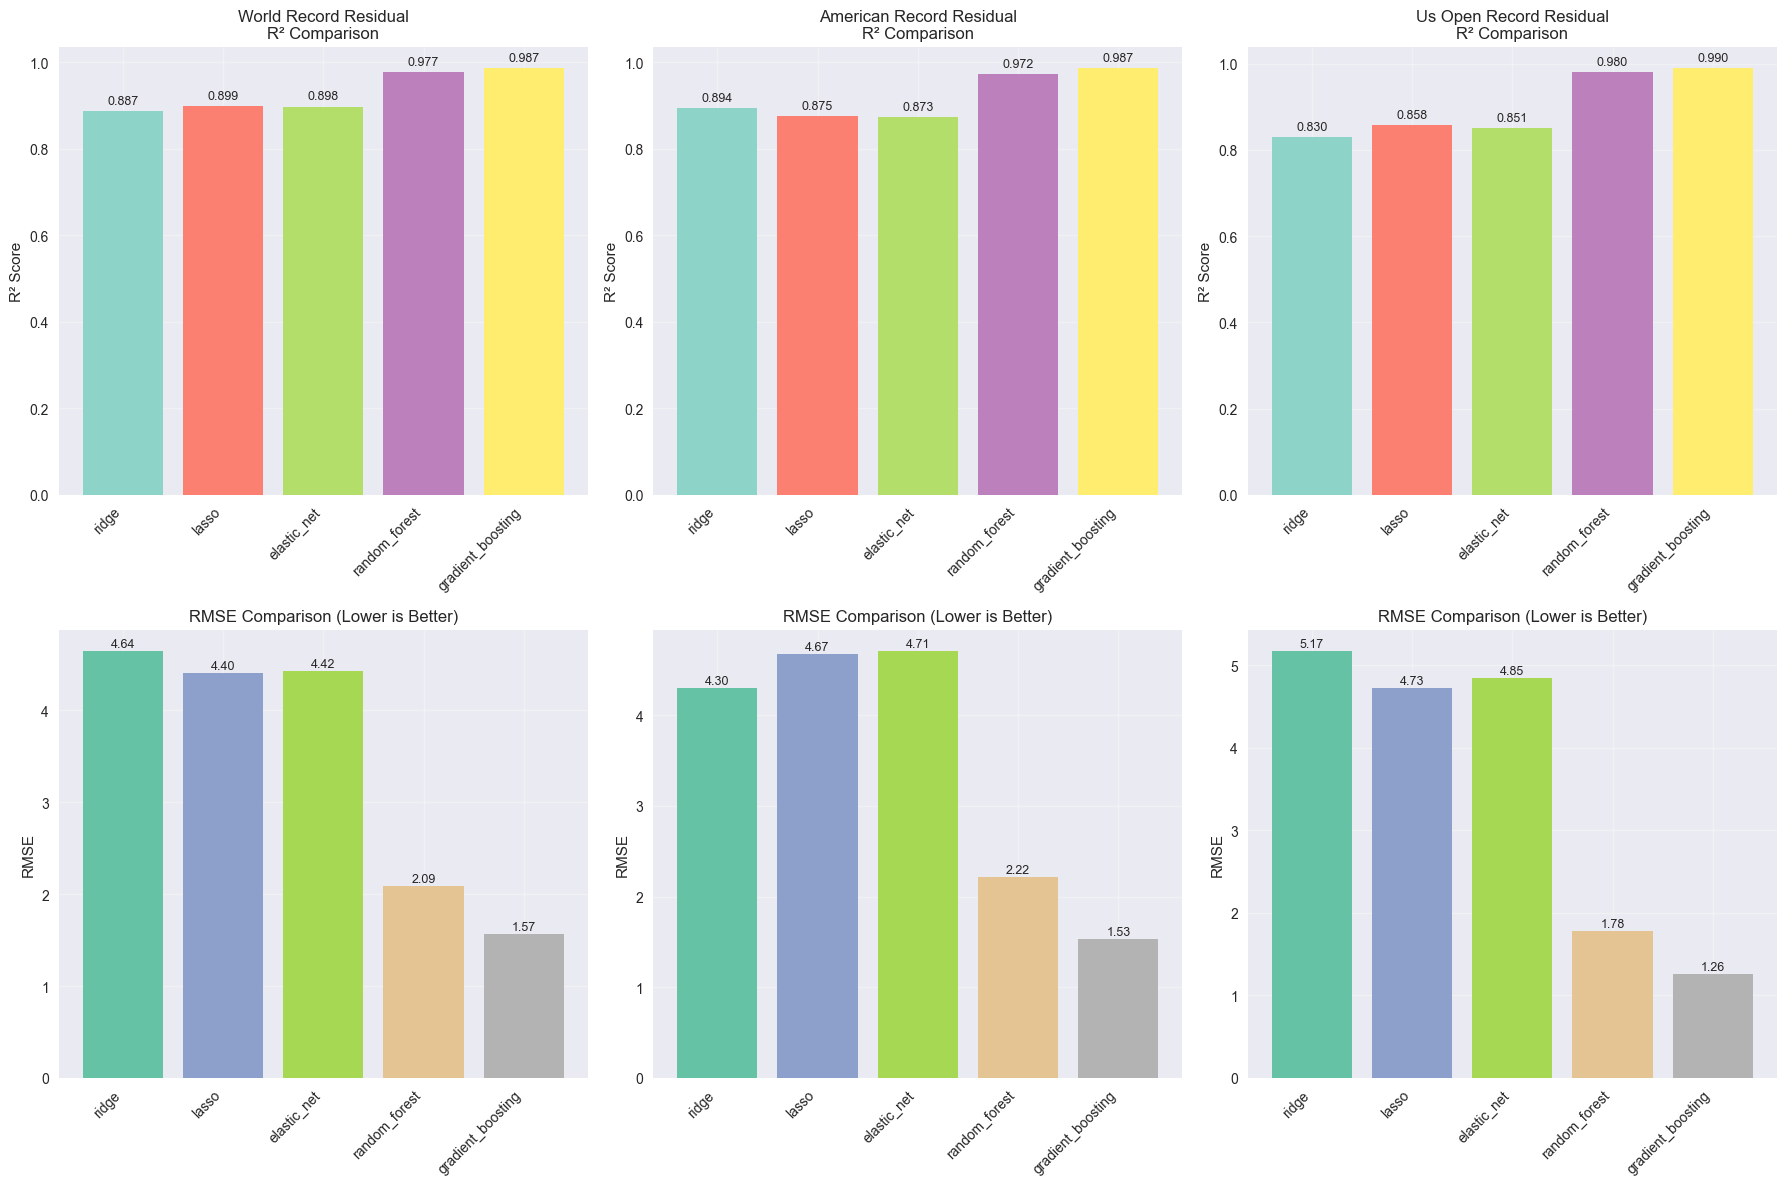

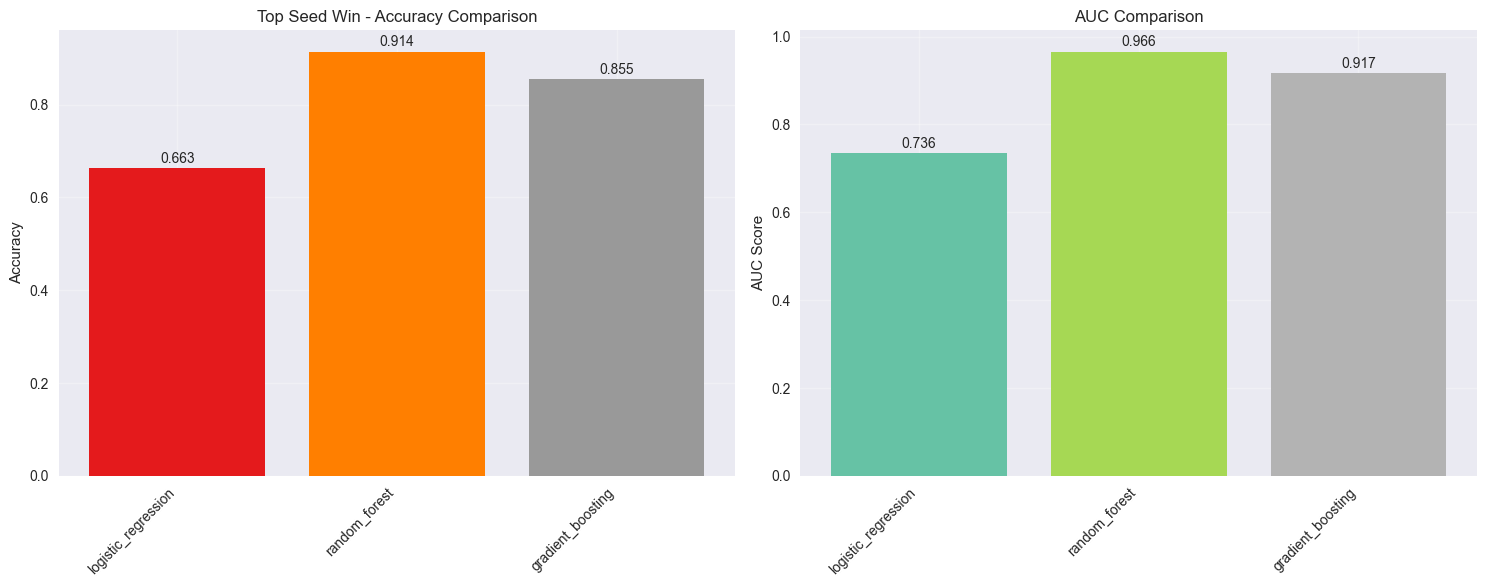

In [32]:
def plot_model_comparison():
    # Prepare data for plotting
    regression_tasks = [task for task in full_evaluation_results.keys() if task != 'top_seed_win']
    
    # Regression model comparison
    if regression_tasks:
        fig, axes = plt.subplots(2, len(regression_tasks), figsize=(6*len(regression_tasks), 12))
        if len(regression_tasks) == 1:
            axes = axes.reshape(-1, 1)
        
        for i, task_name in enumerate(regression_tasks):
            task_results = full_evaluation_results[task_name]
            
            # R² comparison
            ax1 = axes[0, i]
            models = list(task_results.keys())
            r2_scores = [task_results[model]['metrics']['r2'] for model in models]
            
            bars = ax1.bar(range(len(models)), r2_scores, color=plt.cm.Set3(np.linspace(0, 1, len(models))))
            ax1.set_xticks(range(len(models)))
            ax1.set_xticklabels(models, rotation=45, ha='right')
            ax1.set_ylabel('R² Score')
            ax1.set_title(f'{task_name.replace("_", " ").title()}\nR² Comparison')
            ax1.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, score in zip(bars, r2_scores):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{score:.3f}', ha='center', va='bottom', fontsize=9)
            
            # RMSE comparison
            ax2 = axes[1, i]
            rmse_scores = [task_results[model]['metrics']['rmse'] for model in models]
            
            bars = ax2.bar(range(len(models)), rmse_scores, color=plt.cm.Set2(np.linspace(0, 1, len(models))))
            ax2.set_xticks(range(len(models)))
            ax2.set_xticklabels(models, rotation=45, ha='right')
            ax2.set_ylabel('RMSE')
            ax2.set_title('RMSE Comparison (Lower is Better)')
            ax2.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, score in zip(bars, rmse_scores):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{score:.2f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'plots' / 'evaluation' / 'regression_model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Classification model comparison
    if 'top_seed_win' in full_evaluation_results:
        task_results = full_evaluation_results['top_seed_win']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        models = list(task_results.keys())
        
        # Accuracy comparison
        accuracies = [task_results[model]['metrics']['accuracy'] for model in models]
        bars1 = ax1.bar(range(len(models)), accuracies, color=plt.cm.Set1(np.linspace(0, 1, len(models))))
        ax1.set_xticks(range(len(models)))
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Top Seed Win - Accuracy Comparison')
        ax1.grid(True, alpha=0.3)
        
        for bar, score in zip(bars1, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=10)
        
        # AUC comparison
        auc_scores = [task_results[model]['metrics'].get('auc', 0) for model in models]
        bars2 = ax2.bar(range(len(models)), auc_scores, color=plt.cm.Set2(np.linspace(0, 1, len(models))))
        ax2.set_xticks(range(len(models)))
        ax2.set_xticklabels(models, rotation=45, ha='right')
        ax2.set_ylabel('AUC Score')
        ax2.set_title('AUC Comparison')
        ax2.grid(True, alpha=0.3)
        
        for bar, score in zip(bars2, auc_scores):
            if score > 0:  # Only show if AUC is available
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{score:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'plots' / 'evaluation' / 'classification_model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

plot_model_comparison()

In [40]:
def create_final_model_selection():

    final_selections = {}
    
    print("FINAL MODEL SELECTION:")
    
    for task_name, task_results in full_evaluation_results.items():
        print(f"\n{task_name.upper()}:")
        
        if task_name == 'top_seed_win':
            # For classification, prioritize AUC, then accuracy
            best_auc = max((model, result['metrics'].get('auc', 0)) 
                          for model, result in task_results.items() 
                          if result['metrics'].get('auc', 0) > 0)
            
            best_acc = max((model, result['metrics']['accuracy']) 
                          for model, result in task_results.items())
            
            # Choose model with best AUC if available, otherwise best accuracy
            if best_auc[1] > 0:
                selected_model = best_auc[0]
                selection_reason = f"Best AUC: {best_auc[1]:.3f}"
            else:
                selected_model = best_acc[0]
                selection_reason = f"Best Accuracy: {best_acc[1]:.3f}"
            
            final_selections[task_name] = {
                'model': selected_model,
                'reason': selection_reason,
                'metrics': task_results[selected_model]['metrics']
            }
            
        else:
            # For regression, prioritize R², but check for overfitting
            sorted_by_r2 = sorted(task_results.items(), 
                                key=lambda x: x[1]['metrics']['r2'], 
                                reverse=True)
            
            # Get training results to check overfitting
            train_results = training_results[task_name]
            
            best_models_info = []
            for model_name, result in sorted_by_r2[:3]:  # Top 3 models
                train_r2 = train_results[model_name]['train_r2']
                test_r2 = result['metrics']['r2']
                overfitting = train_r2 - test_r2
                
                best_models_info.append({
                    'model': model_name,
                    'test_r2': test_r2,
                    'overfitting': overfitting,
                    'rmse': result['metrics']['rmse']
                })
            
            # Select model with best balance of performance and generalization
            # Prefer models with overfitting < 0.05 and high R²
            suitable_models = [m for m in best_models_info if m['overfitting'] < 0.05]
            
            if suitable_models:
                selected = max(suitable_models, key=lambda x: x['test_r2'])
                selection_reason = f"Best R² ({selected['test_r2']:.3f}) with low overfitting ({selected['overfitting']:.3f})"
            else:
                selected = best_models_info[0]  
                selection_reason = f"Best R² ({selected['test_r2']:.3f}) - Note: overfitting = {selected['overfitting']:.3f}"
            
            final_selections[task_name] = {
                'model': selected['model'],
                'reason': selection_reason,
                'metrics': task_results[selected['model']]['metrics']
            }
        
        print(f"Selected: {final_selections[task_name]['model']}")
        print(f"Reason: {final_selections[task_name]['reason']}")
    
    return final_selections

final_model_selection = create_final_model_selection()

FINAL MODEL SELECTION:

WORLD_RECORD_RESIDUAL:
Selected: gradient_boosting
Reason: Best R² (0.987) with low overfitting (0.010)

AMERICAN_RECORD_RESIDUAL:
Selected: gradient_boosting
Reason: Best R² (0.987) with low overfitting (0.013)

US_OPEN_RECORD_RESIDUAL:
Selected: gradient_boosting
Reason: Best R² (0.990) with low overfitting (0.009)

TOP_SEED_WIN:
Selected: random_forest
Reason: Best AUC: 0.966


In [41]:
def save_best_models():

    best_models_final = {}
    
    for task_name, selection in final_model_selection.items():
        model_name = selection['model']
        model_info = all_models[task_name][model_name]
        
        best_models_final[task_name] = {
            'model': model_info['model'],
            'feature_names': model_info['feature_names'],
            'model_type': model_name,
            'selection_reason': selection['reason'],
            'final_metrics': selection['metrics']
        }
    
    # Save best models
    with open(MODELS_DIR / 'best_models_final.pkl', 'wb') as f:
        pickle.dump(best_models_final, f)
    
    # Save selection metadata
    selection_metadata = {
        'selections': {task: {'model': sel['model'], 'reason': sel['reason']} 
                      for task, sel in final_model_selection.items()},
        'evaluation_timestamp': pd.Timestamp.now().isoformat(),
        'total_models_evaluated': sum(len(models) for models in all_models.values()),
        'selection_criteria': {
            'regression': 'R² score with consideration for overfitting (<0.05 preferred)',
            'classification': 'AUC score when available, otherwise accuracy'
        }
    }
    
    with open(MODELS_DIR / 'best_model_selection_metadata.pkl', 'wb') as f:
        pickle.dump(selection_metadata, f)
    
    
    return best_models_final

best_models_final = save_best_models()

In [42]:
def analyze_feature_importance_best_models():

    print("\nFEATURE IMPORTANCE ANALYSIS:")
    
    importance_results = {}
    
    for task_name, model_selection in final_model_selection.items():
        model_name = model_selection['model']
        model_info = all_models[task_name][model_name]
        model = model_info['model']
        feature_names = model_info['feature_names']
        
        print(f"\n{task_name} ({model_name}):")
        
        # Get feature importance from model
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            importances = model.feature_importances_
            importance_type = "Feature Importances"
        elif hasattr(model, 'coef_'):
            # Linear models
            importances = np.abs(model.coef_).flatten()
            importance_type = "Coefficient Magnitudes"
        else:
            print("No built-in feature importance available")
            continue
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"Top 10 Features ({importance_type}):")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<30} {row['importance']:.4f}")
        
        importance_results[task_name] = {
            'model_name': model_name,
            'importance_type': importance_type,
            'feature_importance': importance_df
        }
    
    return importance_results

feature_importance_results = analyze_feature_importance_best_models()


FEATURE IMPORTANCE ANALYSIS:

world_record_residual (gradient_boosting):
Top 10 Features (Feature Importances):
 1. seed_mean                      0.4160
 2. seed_median                    0.3904
 3. top_seed_vs_us_open_record     0.0712
 4. field_size                     0.0239
 5. hhi_seed_times                 0.0204
 6. meet_total_record_holders      0.0186
 7. us_open_record_time            0.0102
 8. top_seed_world_record_pct      0.0085
 9. seed_iqr                       0.0037
10. world_record_holder_competing  0.0035

american_record_residual (gradient_boosting):
Top 10 Features (Feature Importances):
 1. seed_median                    0.4352
 2. seed_mean                      0.4209
 3. top_seed_american_record_pct   0.0215
 4. field_size                     0.0164
 5. swimmers_within_5pct_us_open   0.0127
 6. meet_avg_competitiveness       0.0114
 7. meet_total_record_holders      0.0098
 8. top_seed_us_open_record_pct    0.0097
 9. hhi_seed_times                 0.0089
10.